In [1]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as ticker
from dask.distributed import Client, wait

In [2]:
####DASK
client = Client(n_workers=8, threads_per_worker=4, memory_limit=32e9, ip="0.0.0.0")
#client = Client(scheduler_file="../../scheduler.json")
# client.re.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.57:8787/status,
Dashboard: http://134.245.3.57:8787/status,Workers: 8
Total threads: 32,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.57:35313,Workers: 8
Dashboard: http://134.245.3.57:8787/status,Total threads: 32
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://134.245.3.57:43649,Total threads: 4
Dashboard: http://134.245.3.57:32833/status,Memory: 29.80 GiB
Nanny: tcp://134.245.3.57:34101,


In [3]:
#parameters
current_data_path = (
    "/gxfs_work/geomar/smomw122/2022_north-sea_oysters_data_ocean/"
    "MetO-NWS-PHY-hi-CUR/"
)

In [4]:
data_files = sorted(Path(current_data_path).glob("2021/0[5,6,7,8,9]/*.nc"))
print(f"found {len(data_files)} data files")

found 153 data files


In [5]:
%%time
dataset = xr.open_mfdataset(data_files, chunks={"time": 24})

CPU times: user 1.56 s, sys: 544 ms, total: 2.11 s
Wall time: 24.5 s


In [6]:
dataset = dataset.chunk({"depth": 1, "time": 24})

In [7]:
subset_2021 = dataset.isel(depth=2)

In [8]:
subset_2021

<xarray.Dataset> Size: 70GB
Dimensions:  (time: 3672, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2021-05-01T01:00:00 ... 2021-10-01
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
    depth    float32 4B 5.0
Data variables:
    uo       (time, lat, lon) float64 35GB dask.array<chunksize=(24, 414, 320), meta=np.ndarray>
    vo       (time, lat, lon) float64 35GB dask.array<chunksize=(24, 414, 320), meta=np.ndarray>
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

In [9]:
subset_day_01 = dataset.isel(depth=2).sel(time='2021-07-01T00:00', method='nearest')
subset_day_02 = dataset.isel(depth=2).sel(time='2021-07-01T06:00', method='nearest')  # 6 hours later

In [10]:
subset_depth = dataset.sel(time='2021-07-01', method = 'nearest')
subset_depth

<xarray.Dataset> Size: 627MB
Dimensions:  (depth: 33, lat: 1240, lon: 958)
Coordinates:
    time     datetime64[ns] 8B 2021-07-01
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (depth, lat, lon) float64 314MB dask.array<chunksize=(1, 414, 320), meta=np.ndarray>
    vo       (depth, lat, lon) float64 314MB dask.array<chunksize=(1, 414, 320), meta=np.ndarray>
Attributes: (12/13)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    institution:          UK Met Office
    history:              See source and creation_date attributes
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...

In [11]:
selected_time = subset_day_01.time.values
print(f"Selected time for subset_day_01: {selected_time}")

Selected time for subset_day_01: 2021-07-01T00:00:00.000000000


In [12]:
selected_time = subset_day_02.time.values
print(f"Selected time for subset_day_02: {selected_time}")

Selected time for subset_day_02: 2021-07-01T06:00:00.000000000


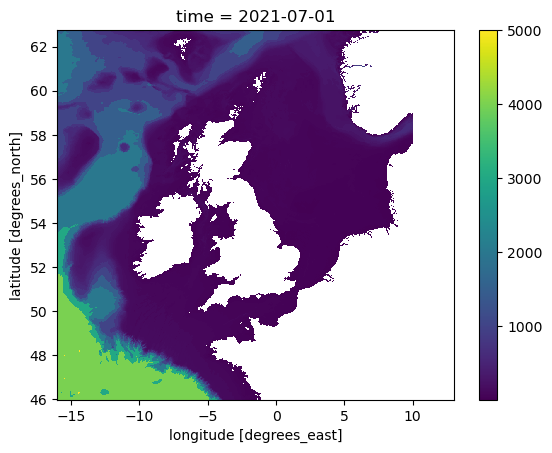

In [39]:
max_depth_curr = (subset_depth.depth * (~subset_depth.uo.isnull())).max("depth")
max_depth_curr = max_depth_curr.where(max_depth_curr > 0)
max_depth_curr.plot()

In [13]:
max_depth_curr

<xarray.DataArray (lat: 1240, lon: 958)> Size: 5MB
dask.array<where, shape=(1240, 958), dtype=float32, chunksize=(414, 320), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2021-07-01
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0

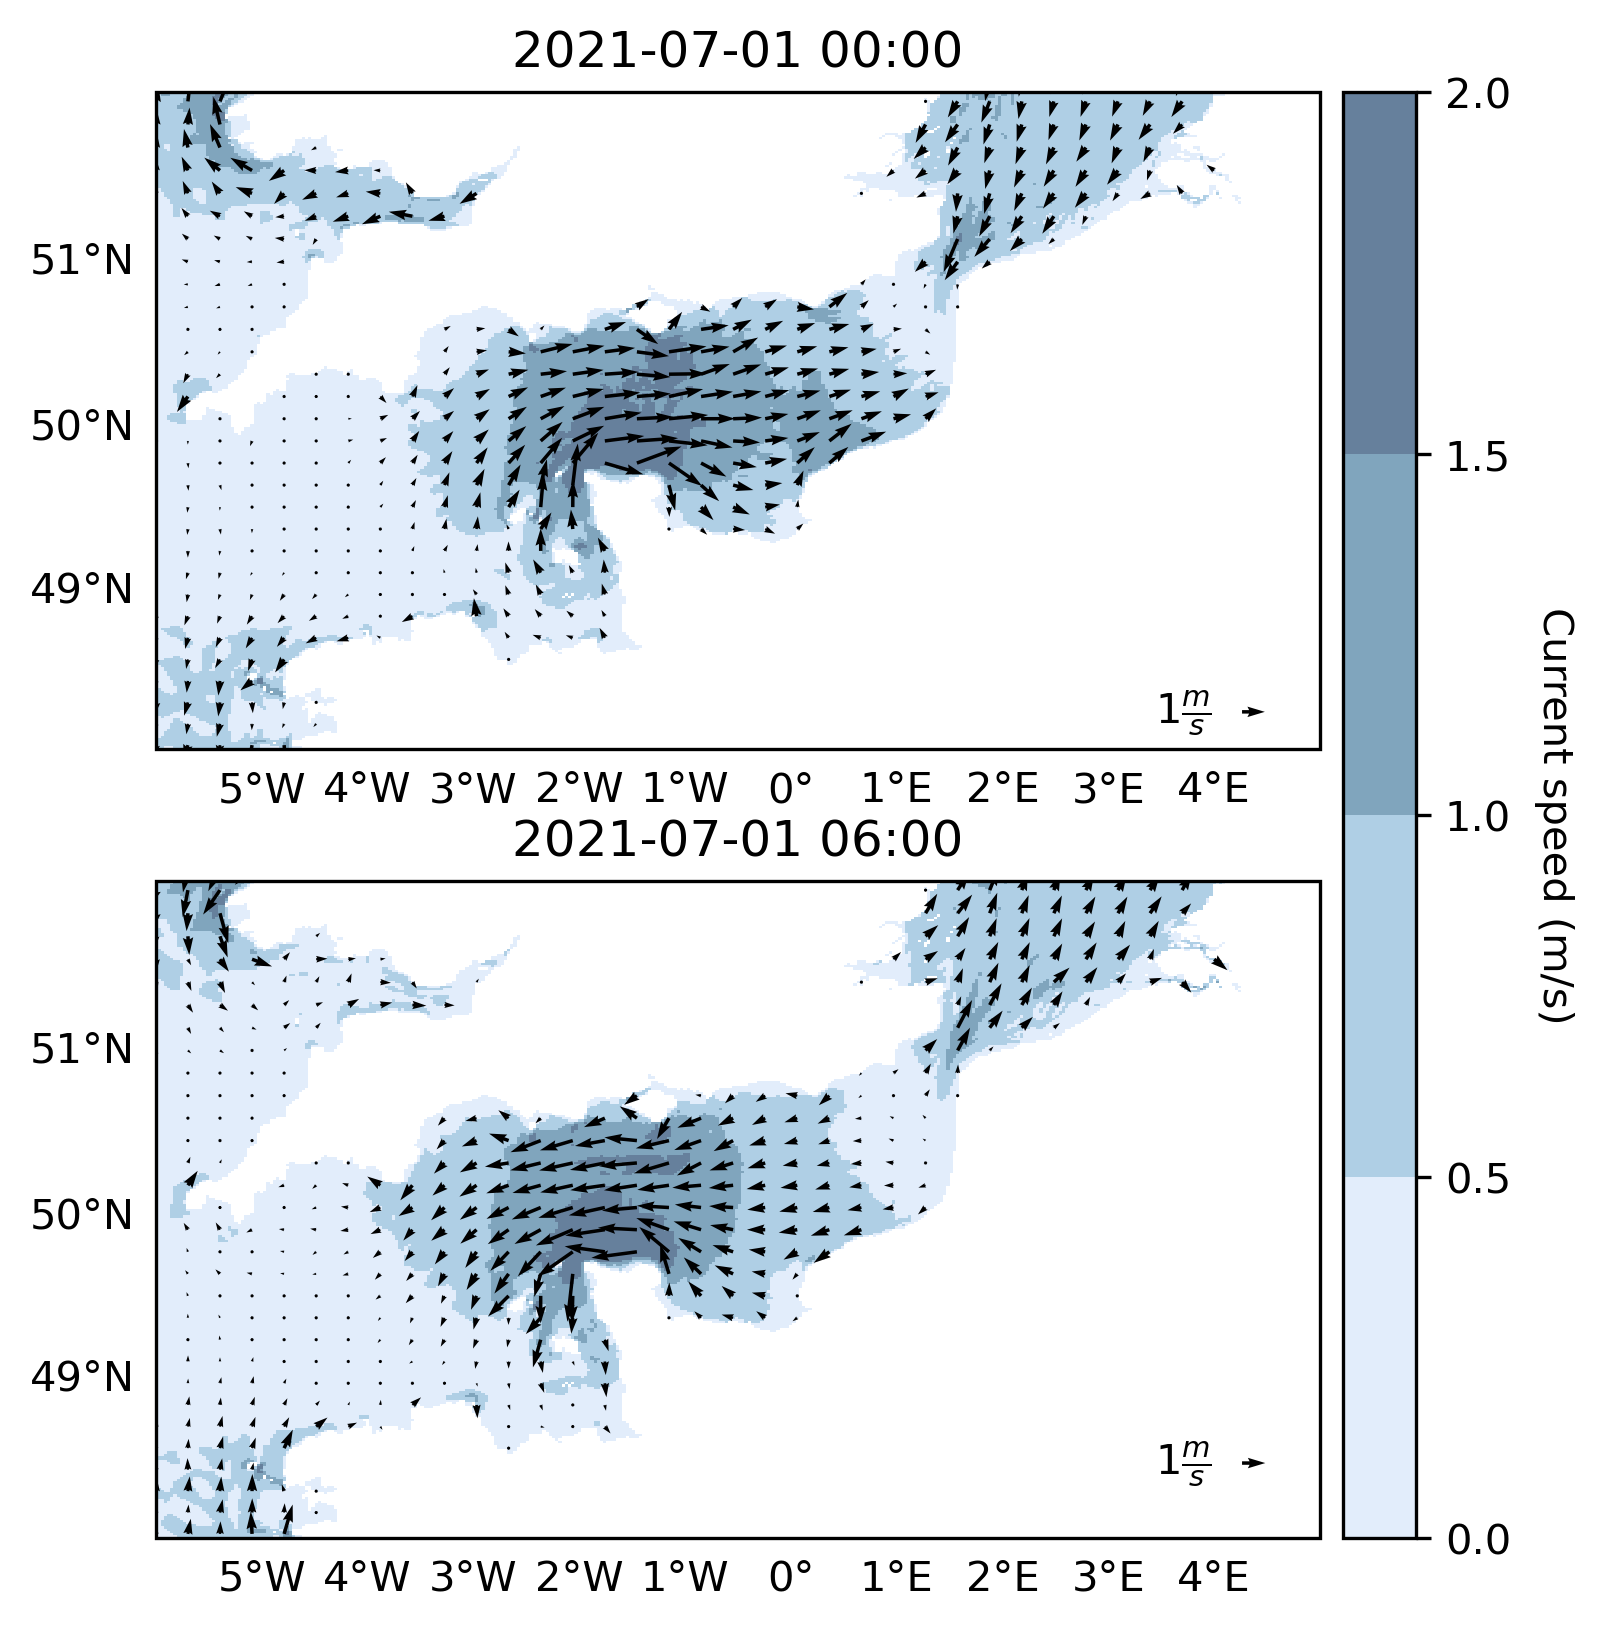

In [41]:
# 01.07.2021 00:00 and 06:00, English Channel

fig, ax = plt.subplots(
    2, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

#speed_categories = [0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2]
speed_categories = [0, 0.50, 1.00, 1.50, 2]

#blue_colors = ['#D0E1F9', '#A6C8E0', '#7BAFD4', '#4F92B4', '#2B6A92', '#005B8D', '#004C7E', '#003B6B', '#002B5A']
blue_colors = ['#D0E1F9', '#7BAFD4', '#2B6A92', '#004C7E', '#002B5A']
cmap = plt.cm.colors.ListedColormap(blue_colors)
norm = BoundaryNorm(speed_categories, ncolors=cmap.N, clip=False)

fig.set_dpi(300)

#ax[0].coastlines(zorder=0)
#ax[1].coastlines(zorder=0)

ax[0].set_title("2021-07-01 00:00")
ax[0].set_extent([-6, 5, 48, 52])
gl0 = ax[0].gridlines(draw_labels=True, zorder=0, alpha=0)
gl0.xlocator = ticker.MultipleLocator(1)  # Set gridlines on the x-axis every 1°
gl0.ylocator = ticker.MultipleLocator(1)  # Set gridlines on the y-axis every 1°
gl0.top_labels=False   # suppress top labels
gl0.right_labels=False # suppress right labels;

ax[1].set_title("2021-07-01 06:00")
ax[1].set_extent([-6, 5, 48, 52])
gl1 = ax[1].gridlines(draw_labels=True, zorder=0, alpha=0);
gl1.xlocator = ticker.MultipleLocator(1)  # Set gridlines on the x-axis every 1°
gl1.ylocator = ticker.MultipleLocator(1)  # Set gridlines on the y-axis every 1°
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels;

u1 = subset_day_01.uo.squeeze().values
v1 = subset_day_01.vo.squeeze().values

u2 = subset_day_02.uo.squeeze().values
v2 = subset_day_02.vo.squeeze().values

speed_data_01 = np.sqrt(u1**2 + v1**2)
speed_data_02 = np.sqrt(u2**2 + v2**2)

max_speed_value = speed_data_01.max()  # Calculate the maximum depth in the dataset
if max_speed_value > 2:
    speed_categories.append(speed_categories) 

lon, lat = np.meshgrid(subset_day_01.lon.values, subset_day_01.lat.values)

#add speed as background
speed_plot1 = ax[0].pcolormesh(lon, lat, speed_data_01, shading='auto', cmap=cmap, norm=norm, transform=cartopy.crs.PlateCarree(), alpha=0.6)
speed_plot2 = ax[1].pcolormesh(lon, lat, speed_data_02, shading='auto', cmap=cmap, norm=norm, transform=cartopy.crs.PlateCarree(), alpha=0.6)

#pick every 10th quiver arrow
skip = (slice(None, None, 10), slice(None, None, 10))

q1 = ax[0].quiver(lon[skip], lat[skip], u1[skip], v1[skip], transform=cartopy.crs.PlateCarree(), color='black', 
                  width=0.003, headwidth=3)
q2 = ax[1].quiver(lon[skip], lat[skip], u2[skip], v2[skip], transform=cartopy.crs.PlateCarree(), color='black', 
                  width=0.003, headwidth=3)

cbar = fig.colorbar(speed_plot1, ax=ax, orientation='vertical', pad=0.01, ticks=speed_categories)
cbar.set_label('Current speed (m/s)', rotation=270, labelpad=15)
#cbar.ax.set_yticklabels([f'{speed} m/s' for speed in speed_categories[:-1]] + ['> 2 m'])  # Custom label for the last category

# Add quiver keys to each subplot with a valid labelpos
ax[0].quiverkey(q1, 0.75, 0.55, 1, r'$1 \frac{m}{s}$', labelpos='W', coordinates='figure')
ax[1].quiverkey(q2, 0.75, 0.15, 1, r'$1 \frac{m}{s}$', labelpos='W', coordinates='figure')

#fig.tight_layout();
fig.savefig("plots/currents_englishchannel.png", dpi=300)

In [13]:
u1 = subset_2021.uo.mean("time").compute()
u1

<xarray.DataArray 'uo' (lat: 1240, lon: 958)> Size: 10MB
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [-0.00654003, -0.00628704, -0.00669662, ...,         nan,
                nan,         nan],
       [-0.00638834, -0.00596296, -0.00591013, ...,         nan,
                nan,         nan],
       ...,
       [ 0.01303704,  0.01228731,  0.01125953, ...,         nan,
                nan,         nan],
       [ 0.00540523,  0.01116803,  0.01624237, ...,         nan,
                nan,         nan],
       [ 0.02672113,  0.01474047,  0.00244499, ...,         nan,
                nan,         nan]])
Coordinates:
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
    depth    float32 4B 5.0

In [14]:
v1 = subset_2021.vo.mean("time").compute()
v1

<xarray.DataArray 'vo' (lat: 1240, lon: 958)> Size: 10MB
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [-0.01835812, -0.01551525, -0.01160784, ...,         nan,
                nan,         nan],
       [-0.01897958, -0.01578431, -0.01186302, ...,         nan,
                nan,         nan],
       ...,
       [ 0.0427451 ,  0.04467674,  0.04600871, ...,         nan,
                nan,         nan],
       [ 0.03964597,  0.0440098 ,  0.04738834, ...,         nan,
                nan,         nan],
       [-0.02198666, -0.03060022, -0.03915959, ...,         nan,
                nan,         nan]])
Coordinates:
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
    depth    float32 4B 5.0

In [15]:
u1 = u1.squeeze().values
v1 = v1.squeeze().values

In [16]:
speed_data_01 = np.sqrt(u1**2 + v1**2)

In [17]:
speed_data_01

array([[0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.01948826, 0.01674066, 0.013401  , ...,        nan,        nan,
               nan],
       [0.02002586, 0.0168731 , 0.01325371, ...,        nan,        nan,
               nan],
       ...,
       [0.04468901, 0.04633562, 0.04736643, ...,        nan,        nan,
               nan],
       [0.04001274, 0.04540471, 0.05009461, ...,        nan,        nan,
               nan],
       [0.03460393, 0.03396549, 0.03923584, ...,        nan,        nan,
               nan]])

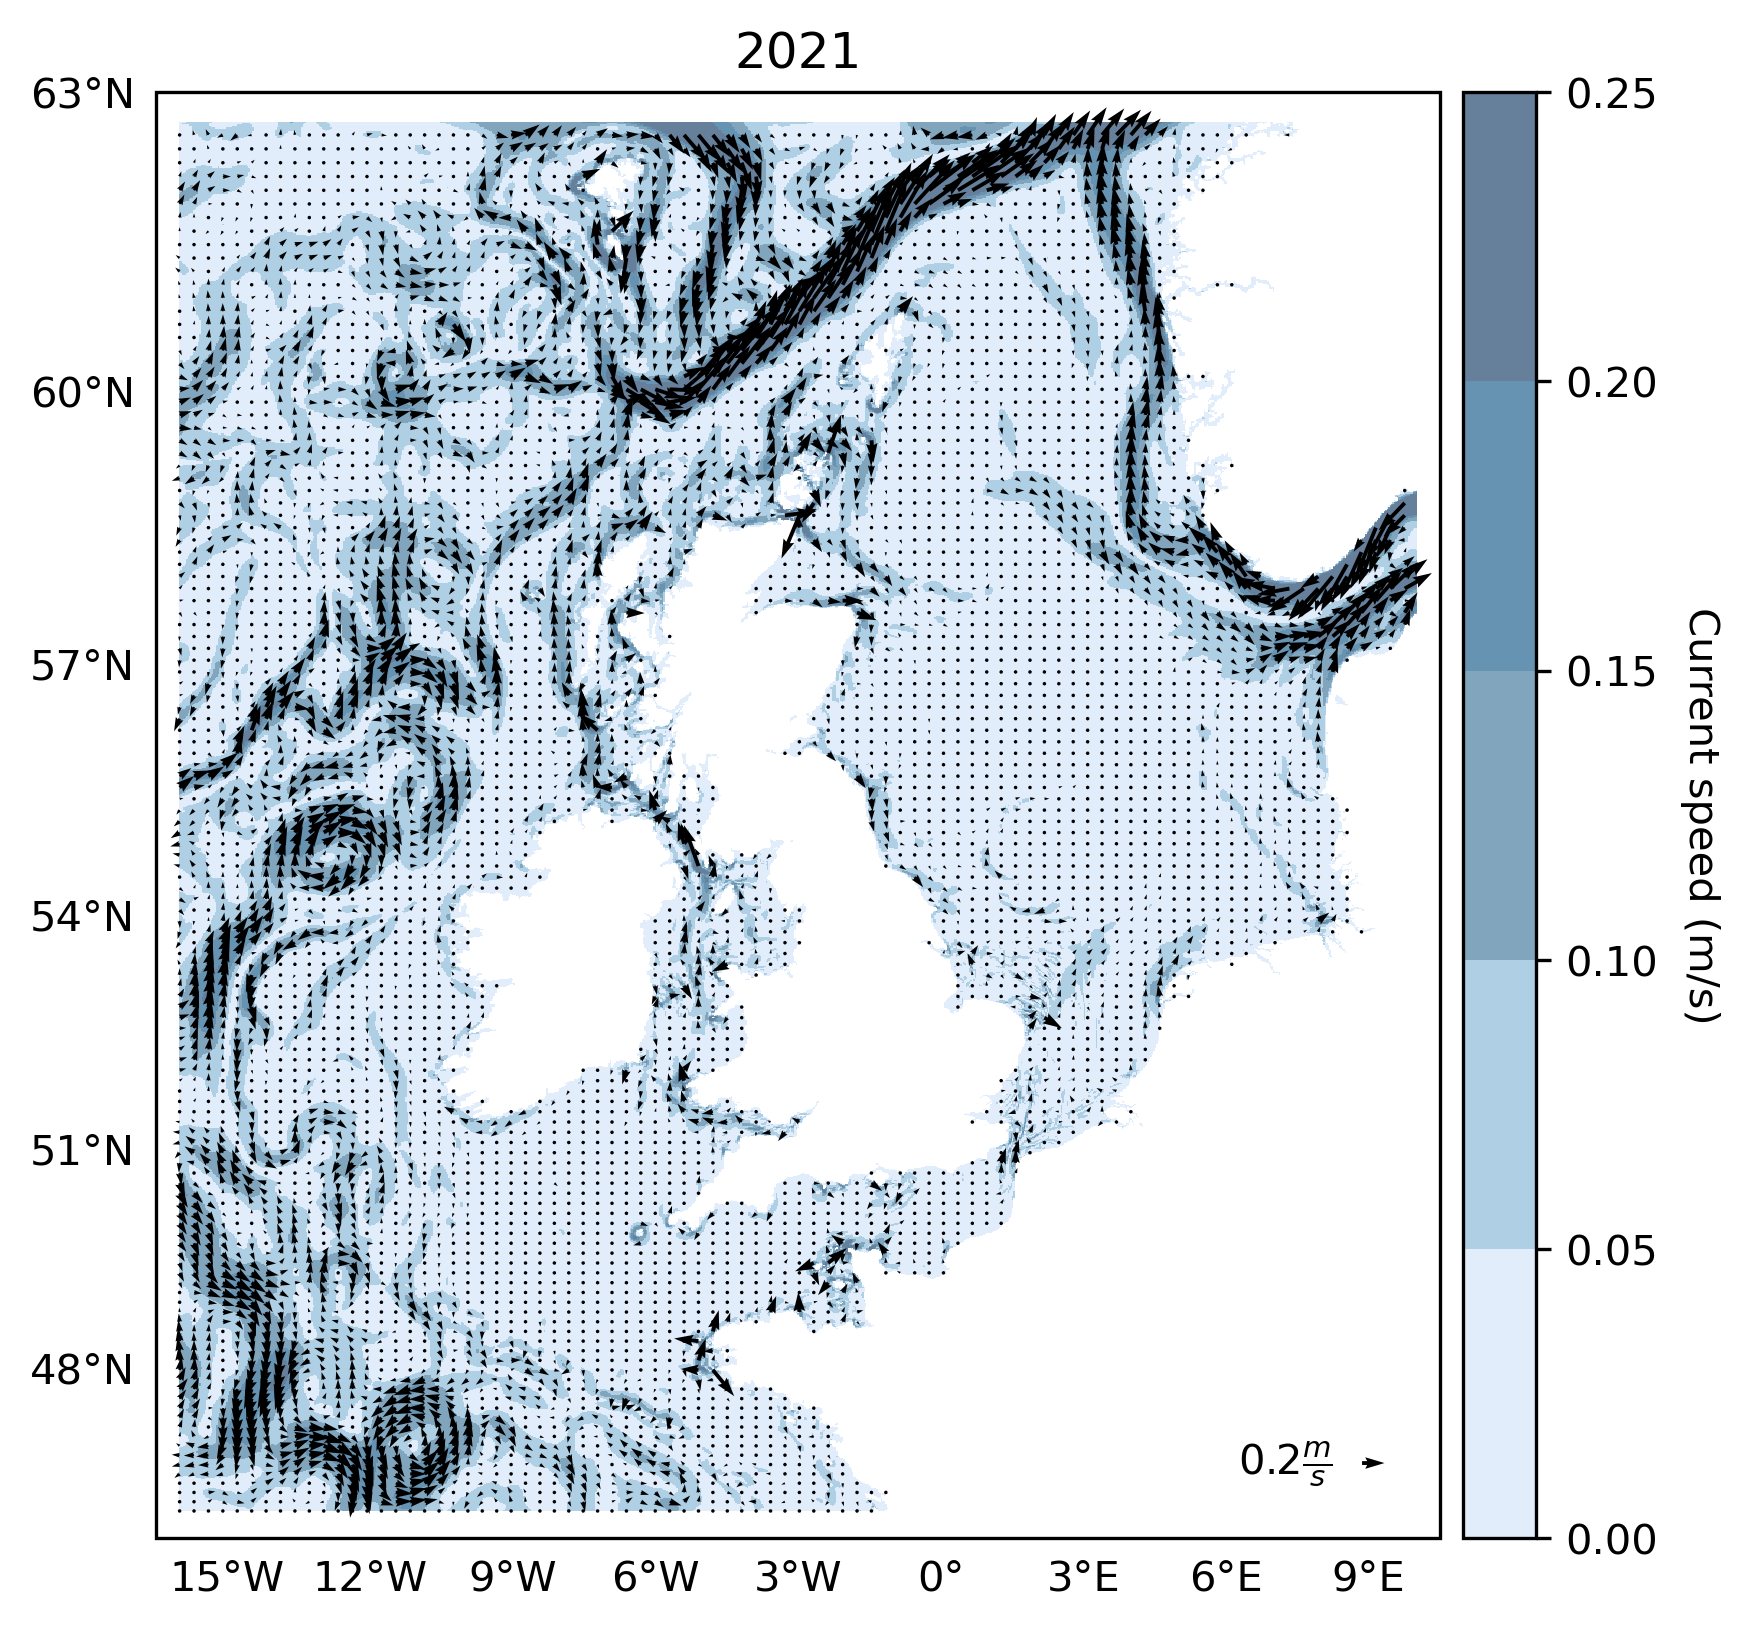

In [38]:
# Average, entire model domain

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator()},
    figsize=(10, 6.26),
)

#speed_categories = [0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2]
speed_categories = [0, 0.05, 0.10, 0.15, 0.2, 0.25]

#blue_colors = ['#D0E1F9', '#A6C8E0', '#7BAFD4', '#4F92B4', '#2B6A92', '#005B8D', '#004C7E', '#003B6B', '#002B5A']
blue_colors = ['#D0E1F9', '#7BAFD4', '#2B6A92', '#004C7E', '#002B5A']
cmap = plt.cm.colors.ListedColormap(blue_colors)
norm = BoundaryNorm(speed_categories, ncolors=cmap.N, clip=False)

fig.set_dpi(300)

#ax[0].coastlines(zorder=0)
#ax[1].coastlines(zorder=0)

ax.set_title("2021")
ax.set_extent([-16.5, 10.5, 45.6, 62.4])
gl0 = ax.gridlines(draw_labels=True, zorder=0, alpha=0)
gl0.xlocator = ticker.MultipleLocator(3)  # Set gridlines on the x-axis every 1°
gl0.ylocator = ticker.MultipleLocator(3)  # Set gridlines on the y-axis every 1°
gl0.top_labels=False   # suppress top labels
gl0.right_labels=False # suppress right labels;

lon, lat = np.meshgrid(subset_2021.lon.values, subset_2021.lat.values)

max_speed_value = speed_data_01.max()  # Calculate the maximum depth in the dataset
if max_speed_value > 2:
    speed_categories.append(speed_categories) 

#add speed as background
speed_plot1 = ax.pcolormesh(lon, lat, speed_data_01, shading='auto', cmap=cmap, norm=norm, transform=cartopy.crs.PlateCarree(), alpha=0.6)

#pick every 10th quiver arrow
skip = (slice(None, None, 10), slice(None, None, 10))

q1 = ax.quiver(lon[skip], lat[skip], u1[skip], v1[skip], transform=cartopy.crs.PlateCarree(), color='black', 
                  width=0.003, headwidth=3)

cbar = fig.colorbar(speed_plot1, ax=ax, orientation='vertical', pad=0.01, ticks=speed_categories)
cbar.set_label('Current speed (m/s)', rotation=270, labelpad=15)
#cbar.ax.set_yticklabels([f'{speed} m/s' for speed in speed_categories[:-1]] + ['> 2 m'])  # Custom label for the last category

# Add quiver keys to each subplot with a valid labelpos
ax.quiverkey(q1, 0.75, 0.15, 0.2, r'$0.2 \frac{m}{s}$', labelpos='W', coordinates='figure')

#fig.tight_layout();
fig.savefig("plots/currents_entiredomain.png", dpi=300)